In [1]:
# initial set-up
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam
from sewar.full_ref import rmse, uqi
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

torch.manual_seed(0)
np.random.seed(0)

c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#  CONFIGURATIONS - HYPER PARAMETERS
################################################################
#  configurations - HYPER PARAMETERS
################################################################

batch_size = 10
learning_rate = 0.001

epochs = 100
step_size = 50
gamma = 0.5

modes = 16
width = 64

weight_decay=1e-4

# Hyperparameters to change - epoch{10,100,200}, step_size{}, batchsize{}, gamma{}, modes{}, weight_decay{}

In [3]:
#   DEFINING THE TOP FOURIER LAYER
#####################################################################
#   DEFINING THE TOP FOURIER LAYER
#####################################################################

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        # batch matrix multiplication
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

In [4]:
# DIFFERENING MODELS WITH DIFFERING FOURIER LAYERS

#####################################################################
#  1 FOURIER LAYER
#####################################################################
class FNO1_1L(nn.Module):
    def __init__(self, modes, width):
        super(FNO1_1L, self).__init__()

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)


#####################################################################
#  2 FOURIER LAYER
#####################################################################
class FNO1_2L(nn.Module):
    def __init__(self, modes, width):
        super(FNO1_2L, self).__init__()

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 2)


    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)



# Split into W and R.

#####################################################################
#  4 FOURIER LAYER
#####################################################################
class FNO1_4L(nn.Module):
    def __init__(self, modes, width):
        super(FNO1_4L, self).__init__()

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)



#####################################################################
# 6 FOURIER LAYER
#####################################################################
class FNO1_6L(nn.Module):
    def __init__(self, modes, width):
        super(FNO1_6L, self).__init__()

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)
        # weight outputs are diaganol. 

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv4 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv5 = SpectralConv1d(self.width, self.width, self.modes1)


        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.w4 = nn.Conv1d(self.width, self.width, 1)
        self.w5 = nn.Conv1d(self.width, self.width, 1)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x1 = self.conv4(x)
        x2 = self.w4(x)
        x = x1 + x2


        x1 = self.conv5(x)
        x2 = self.w5(x)
        x = x1 + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)




#####################################################################
# 8 FOURIER LAYER
#####################################################################
class FNO1_8L(nn.Module):
    def __init__(self, modes, width):
        super(FNO1_8L, self).__init__()

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv4 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv5 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv6 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv7 = SpectralConv1d(self.width, self.width, self.modes1)



        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.w4 = nn.Conv1d(self.width, self.width, 1)
        self.w5 = nn.Conv1d(self.width, self.width, 1)
        self.w6 = nn.Conv1d(self.width, self.width, 1)
        self.w7 = nn.Conv1d(self.width, self.width, 1)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x1 = self.conv4(x)
        x2 = self.w4(x)
        x = x1 + x2


        x1 = self.conv5(x)
        x2 = self.w5(x)
        x = x1 + x2

        x1 = self.conv6(x)
        x2 = self.w6(x)
        x = x1 + x2

        x1 = self.conv7(x)
        x2 = self.w7(x)
        x = x1 + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)




In [10]:
raw_data = scipy.io.loadmat('./datasets/training_data_16x16_10k')

sol = np.asarray(raw_data['solution_data'])
mes = np.asarray(raw_data['measurement_data'])

sol_temp = np.expand_dims(sol,axis = 1 )
#sol_temp = np.sqeeze(sol_temp)
mes_temp = np.transpose(np.expand_dims(mes,axis = 1 ),(0,2,1))


def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y

# we are solving the inverse problem, so going from measurements, to solutions
X, y = convert_data(mes_temp, sol_temp)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

#batch_size = 10

#train_loader = DataLoader(data_utils.TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ntrain = X_train.shape[0]
ntest = X_test.shape[0]

print(X_train.shape, y_train.shape)

torch.Size([8000, 128, 1]) torch.Size([8000, 256])


In [14]:
# TRAINING AND EVALUATION
################################################################
# TRAINING AND EVALUATION
################################################################


def train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma):
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_losses, test_losses, epoch_time = [], [], []

    myloss = LpLoss(size_average=False)
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_mse = 0
        train_l2 = 0
        total_time = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            #print('in: ',x.shape)
            out = model(x)
            #print('out: ',out.shape)

            mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            l2.backward() # use the l2 relative loss

            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        #train_mse /= len(train_loader)
        train_l2 /= ntrain
        train_losses.append(train_l2)
        test_l2 /= ntest
        test_losses.append(test_l2)


        t2 = default_timer()
        epoch_time.append(t2 - t1)
        total_time += (t2-t1)
        print(ep, t2 - t1, train_l2, test_l2)
    
    print("TOTAL TIME: ", total_time, sep="---")

    output = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "epoch_time": epoch_time,
    "training_time": total_time,
    "model": model
    }
    return output 
# torch.save(model, 'model/ns_fourier_burgers')

# scipy.io.savemat('pred/burger_test.mat', mdict={'pred': pred.cpu().numpy()})

In [15]:
# MODEL METRICS
###################################
# MODEL METRICS
###################################
def model_metrics(model,test_loader,ntrain):
    rms_values, psnr_values, ssim_values, uqi_values = [], [], [], []

    for test_num in range(ntest):
        K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
        model.eval()
        predicted_np = np.reshape(model(K).detach().cpu().numpy(),(16,16))

        truth = test_loader.dataset[test_num][1]
        truth_np = np.reshape(truth.numpy(),(16,16))

        #diff_image = predicted - truth_np
        #np.sqrt(np.sum(diff_image**2)/256)

        rms_values.append(rmse(predicted_np, truth_np))
        psnr_values.append(psnr(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        ssim_values.append(ssim(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        uqi_values.append(uqi(predicted_np, truth_np))

    model_rms = sum(rms_values)/ len(rms_values)
    std_rms = np.std(np.array(rms_values))

    model_psnr = sum(psnr_values)/ len(psnr_values)
    std_psnr = np.std(np.array(psnr_values))

    model_ssim = sum(ssim_values)/ len(ssim_values)
    std_ssim = np.std(np.array(ssim_values))

    model_uqi = sum(uqi_values)/ len(uqi_values)
    std_uqi = np.std(np.array(uqi_values))


    print("RMSE: ", model_rms, std_rms, sep="---")
    print("PSNR: ", model_psnr, std_psnr, sep="---")
    print("SSIM: ", model_ssim, std_ssim, sep="---")
    print("UQI: ", model_uqi, std_uqi, sep="---")


    output = {
    "rms": rms_values,
    "psnr": psnr_values,
    "ssim": ssim_values,
    "uqi": uqi_values,
    }
    return output 

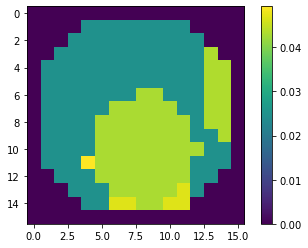

In [19]:
#Actual
test_num = 434
truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()

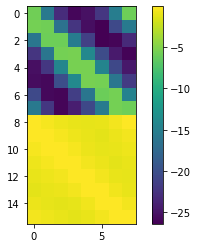

In [21]:
truth_out = test_loader.dataset[test_num][0]
plt.imshow(np.reshape(truth_out.numpy(),(16,8)))
plt.colorbar()

144002
0 7.196735700010322 0.40674223664402964 0.1796461563706398
1 3.1227738999878056 0.18428635244071484 0.1715457478761673
2 3.085418500006199 0.17095361398160458 0.17763629305362702
3 3.00643469998613 0.16579511779546738 0.16656675875186921
4 3.004730799992103 0.1642909388691187 0.15395165187120438
5 3.021129100001417 0.1616764949709177 0.15831468600034715
6 3.088254300004337 0.15965173396468163 0.15455500388145446
7 3.0422729999991134 0.15899217101931573 0.16375114625692366
8 3.014497400028631 0.15681196697056293 0.1586033272743225
9 3.0146820999798365 0.15609750042855738 0.1523639783859253
10 3.058275000017602 0.15436929008364678 0.15175512599945068
11 3.0241766999824904 0.15189817878603934 0.15035941761732102
12 3.034877599973697 0.15045007418841125 0.14900340563058853
13 3.0399169000447728 0.14981511525809765 0.1490183962583542
14 2.995468500012066 0.14846872060745955 0.1469753630757332
15 3.031753799994476 0.14756137654185295 0.14261692255735398
16 3.0360856999759562 0.1456477

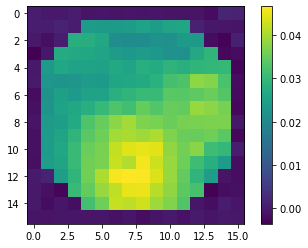

In [13]:
# ONE LAYER RESULTS
############################################################################

model_1L = FNO1_1L(modes, width).cuda()
print(count_params(model_1L))
output_1L = train_model(model_1L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_1L_model = output_1L.get("model")
torch.save(output_1L_model, 'fno1_1l.h5')
results_1L = model_metrics(output_1L_model,test_loader,ntrain)

# ONE LAYER RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_1L_model.eval()
predicted = np.reshape(output_1L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

279234
0 4.151774600031786 0.2595294766575098 0.15780726540088655
1 4.0751997999614105 0.1535752113312483 0.14311176708340645
2 4.0986588999512605 0.1447731086462736 0.14903092426061632
3 4.108540999994148 0.14182372995465994 0.13722228384017945
4 4.0966108000138775 0.1384735744893551 0.13739443641901017
5 4.0581099999835715 0.13648573550581933 0.1318184673190117
6 4.090068700024858 0.1336107279136777 0.13228184115886688
7 4.09933739999542 0.13270901162177323 0.13068380218744277
8 4.093399600009434 0.1312423707395792 0.12965152010321618
9 4.169808000035118 0.1295991738960147 0.12893697386980058
10 4.108623299980536 0.12941475949436426 0.12526482877135275
11 4.093571199977305 0.12725699899345636 0.12489828571677208
12 4.087709000043105 0.1262984892502427 0.1266512666940689
13 4.104753499967046 0.12536955223977567 0.122348357796669
14 4.131080999970436 0.12377855128794908 0.12249896892905235
15 4.183345300029032 0.12360450994223356 0.12071754249930382
16 4.0970501999836415 0.121885271780

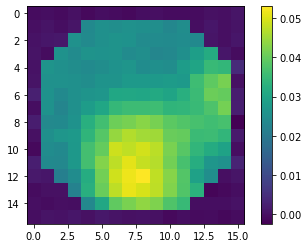

In [14]:
# TWO LAYER RESULTS
############################################################################

model_2L = FNO1_2L(modes, width).cuda()
print(count_params(model_2L))
output_2L = train_model(model_2L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_2L_model = output_2L.get("model")
torch.save(output_2L_model, 'fno1_2l.h5')


results_2L = model_metrics(output_2L_model,test_loader,ntrain)

# TWO LAYER RESULTS
############################################################################
output_2L_model.eval()
predicted = np.reshape(output_2L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

549698
0 6.174244900001213 0.18514237754046917 0.16615179431438445
1 6.130873600021005 0.1442393345683813 0.14146057295799255
2 6.14995849999832 0.13756493551284074 0.13177018415927888
3 6.0879038000130095 0.13228589607030153 0.12847652292251588
4 6.087925700005144 0.1293164548650384 0.12753275114297866
5 6.064095199981239 0.1267332232668996 0.13071003952622415
6 6.0948844000231475 0.1246943739950657 0.12913389483094215
7 6.117122300027404 0.12403250723332167 0.12476966267824173
8 6.101196599949617 0.12150253660976887 0.12463733506202698
9 6.098179200023878 0.12114204992353916 0.12031641358137131
10 6.058344199962448 0.11899547895789146 0.11976098334789276
11 6.06628810003167 0.11766552267968655 0.11517025497555733
12 6.050335999985691 0.1166207195147872 0.1142849087715149
13 6.16036300000269 0.11477521838247776 0.11404477652907372
14 6.063408899994101 0.11300158529728652 0.11676953315734863
15 6.072028099966701 0.11188145394623279 0.11296943446993828
16 6.166073900007177 0.11068673786

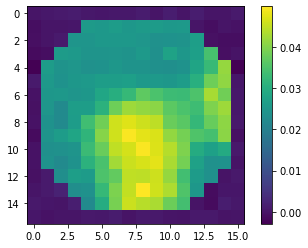

In [15]:
# FOUR LAYER RESULTS
############################################################################

model_4L = FNO1_4L(modes, width).cuda()
print(count_params(model_4L))
output_4L = train_model(model_4L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_4L_model = output_4L.get("model")
torch.save(output_4L_model, 'fno1_4l.h5')


results_4L = model_metrics(output_4L_model,test_loader,ntrain)

# FOUR LAYER RESULTS
############################################################################
output_4L_model.eval()
predicted = np.reshape(output_4L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

820162
0 8.140928799984977 0.19338392943143845 0.1468312373161316
1 8.122203500010073 0.14339351690560578 0.13937179797887803
2 8.026154699968174 0.13641063160449265 0.131577906280756
3 8.078367699985392 0.1322213108614087 0.1370261921286583
4 7.947937900025863 0.12882859003543853 0.1241217525601387
5 7.937617599964142 0.12630030077695847 0.12919652435183526
6 7.946283600002062 0.1253377765417099 0.12338193595409393
7 7.9480934999883175 0.12308589275181293 0.12251488175988197
8 7.989607399969827 0.12141708190739155 0.1267319627702236
9 7.965316499990877 0.12010504280030727 0.11877955439686776
10 7.966549000004306 0.11923825974017381 0.11933212330937386
11 7.924535300000571 0.11895269490033387 0.11663846674561501
12 8.08246639999561 0.11740515239536763 0.11730772510170936
13 7.93455940001877 0.11630661675333977 0.11515531399846077
14 8.033773099945392 0.11446547700464725 0.11638129940629005
15 7.962765700009186 0.11438898283988237 0.11504935720562935
16 8.028074999980163 0.1131947285383

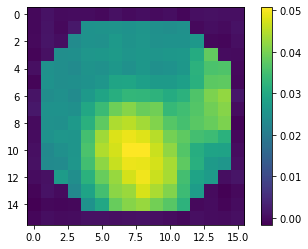

In [16]:
# SIX LAYER RESULTS
############################################################################

model_6L = FNO1_6L(modes, width).cuda()
print(count_params(model_6L))
output_6L = train_model(model_6L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_6L_model = output_6L.get("model")
torch.save(output_6L_model, 'fno1_6l.h5')


results_6L = model_metrics(output_6L_model,test_loader,ntrain)

# SIX LAYER RESULTS
############################################################################
output_6L_model.eval()
predicted = np.reshape(output_6L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

1090626
0 9.932704899983946 0.19463550344109534 0.14464014622569085
1 9.834571199957281 0.14569371577352286 0.1380652754306793
2 9.82018139999127 0.13825480668246745 0.13271474280953408
3 9.840211800008547 0.1335966268032789 0.12757292625308037
4 9.884350900014397 0.13026601811498403 0.13327633038163186
5 10.052396599960048 0.1280328745096922 0.13012514784932136
6 9.793226899986621 0.12625585579127074 0.12542672049999237
7 9.823928700003307 0.12461230419576168 0.12952425220608713
8 9.885979499958921 0.12330249348282814 0.12146946030855178
9 9.871740199974738 0.12231976057589054 0.12001122200489044
10 10.004910300020128 0.12077747540175915 0.1273856853544712
11 10.272973000013735 0.12002703888714314 0.1202031409740448
12 10.257395200023893 0.1186651993021369 0.11671039450168609
13 10.184535900014453 0.11687092573195695 0.12441822811961174
14 10.17610290000448 0.11618157252669334 0.11586290964484215
15 10.15469049999956 0.11459322998672723 0.11415149581432342
16 10.22498070000438 0.11385

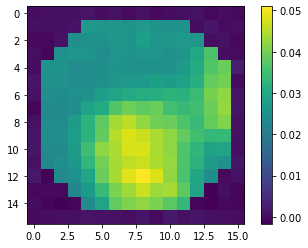

In [17]:
# EIGHT LAYER RESULTS
############################################################################

model_8L = FNO1_8L(modes, width).cuda()
print(count_params(model_8L))
output_8L = train_model(model_8L, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_8L_model = output_8L.get("model")
torch.save(output_8L_model, 'fno1_8l.h5')


results_8L = model_metrics(output_8L_model,test_loader,ntrain)

# EIGHT LAYER RESULTS
############################################################################
output_8L_model.eval()
predicted = np.reshape(output_8L_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

<function matplotlib.pyplot.show(close=None, block=None)>

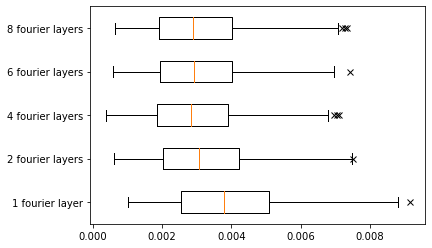

In [18]:
fig1, ax1 = plt.subplots()
red_cross = dict(markerfacecolor='r', marker='x')
data = (results_1L.get("rms"), results_2L.get("rms"), results_4L.get("rms"), results_6L.get("rms"), results_8L.get("rms"))
labels = ('1 fourier layer', '2 fourier layers', '4 fourier layers', '6 fourier layers', '8 fourier layers')

ax1.boxplot(data, vert=False, flierprops=red_cross)
plt.yticks(np.arange(len(labels))+1,labels)
plt.show

# Further Analysis

In [12]:
model = torch.load( './models/fno1_4l.h5')
model.eval()

FNO1_4L(
  (fc0): Linear(in_features=2, out_features=64, bias=True)
  (conv0): SpectralConv1d()
  (conv1): SpectralConv1d()
  (conv2): SpectralConv1d()
  (conv3): SpectralConv1d()
  (w0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (w3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [13]:
results = model_metrics(model,test_loader,ntrain)

RMSE: ---0.0028946503676372743---0.001376380181522979
PSNR: ---25.55615333009154---3.4177125903484478
SSIM: ---0.8745045623039319---0.04397370631207591
UQI: ---0.9936046204007094---0.004814923299372543


<function matplotlib.pyplot.show(close=None, block=None)>

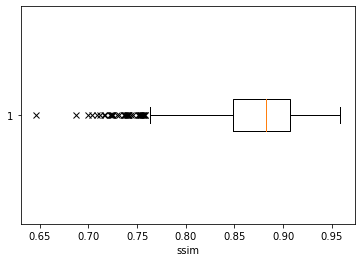

In [166]:
metric_type = 'ssim'         # can be the following rms, ssim, psnr

fig1, ax1 = plt.subplots()
red_cross = dict(markerfacecolor='r', marker='x')
data = (results.get(metric_type))

ax1.boxplot(data, vert=False, flierprops=red_cross)
plt.xlabel(metric_type)
plt.show

In [168]:
# Create outlier range
q75, q25 = np.percentile(data, [75 ,25])
iqr = q75 - q25
outliers = [q25-1.5*iqr,q75+1.5*iqr]

# zip data
data_no = range(len(data))
listed_data = zip(data_no,data)

data_list = list(listed_data)



print('outliers are anything below ',outliers[0],' or above ',outliers[1])

outlier_list = []
for i in range(len(data)):
    if data_list[i][1] < outliers[0]:
        outlier_list.append(data_list[i])
    elif data_list[i][1] > outliers[1]:
        outlier_list.append(data_list[i])


outliers are anything below  0.7605975790694355  or above  0.9955322651937604


In [169]:
print('the number of outliers are ',len(outlier_list) )
#worst reconstruction
worst = [np.min(np.asarray(outlier_list)[:,1]), np.max(np.asarray(outlier_list)[:,1]) ]
print('for outliers, the lowest metric value is ',worst[0],' and highest is', worst[1])

# The values for the worst performers! 
for i in range(len(outlier_list)):
    if outlier_list[i][1] ==  worst[0]:
        print(outlier_list[i])
    elif outlier_list[i][1] == worst[1]:
        print(outlier_list[i])


the number of outliers are  38
for outliers, the lowest metric value is  0.6458793946076185  and highest is 0.758028408586979
(11, 0.6458793946076185)
(469, 0.758028408586979)


In [170]:
print(outlier_list)

[(11, 0.6458793946076185), (15, 0.7317335395514966), (47, 0.7360059870313853), (72, 0.757514780163765), (96, 0.7514397016167641), (201, 0.7532610933668912), (205, 0.7509385472536088), (303, 0.7408771118521691), (314, 0.7528085832297802), (408, 0.7578902839124203), (410, 0.7555989852547645), (412, 0.7437134182080627), (469, 0.758028408586979), (539, 0.745707793510519), (545, 0.7539971178770065), (682, 0.7235779768228531), (750, 0.7243137860298157), (753, 0.7409269170463085), (759, 0.7292254517413675), (775, 0.7238119912147521), (823, 0.7086074970103801), (939, 0.7373311465233564), (964, 0.7557848236605059), (970, 0.7031246799230576), (1001, 0.7226267969608307), (1218, 0.7256091380119324), (1331, 0.7115033964812756), (1394, 0.7385592818260193), (1531, 0.7164411564171315), (1573, 0.7545085688401013), (1635, 0.6997728721797466), (1661, 0.7542089971899987), (1693, 0.7364997550845146), (1750, 0.716685858424753), (1784, 0.7402453853189945), (1886, 0.7419008302688599), (1932, 0.686727730035781

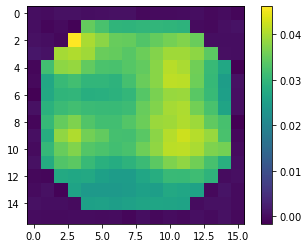

In [171]:
test_num = 11

# Quickly showing that our model gives expected results. 
model.eval()
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
predicted = np.reshape(model(K).detach().cpu().numpy(),(16,16))

plt.imshow(predicted)
plt.colorbar()

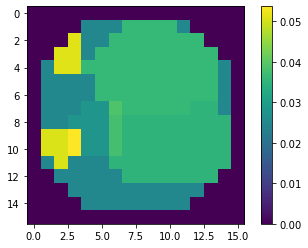

In [172]:
#Actual
truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()

In [56]:
''''
[(13, 37.45871271311937), (105, 34.198502499329095), (176, 34.99373271104959), (279, 35.956186650387565), (329, 37.45871271311937), (351, 37.45871271311937), (418, 34.33680867450399), (463, 34.60681511924516), (556, 37.45871271311937), (571, 34.680421727466026), (572, 36.35967095181604), (582, 34.784840900981514), (721, 34.08103264947673), (758, 35.10849597834047), (810, 34.432132882415516), (816, 35.45720489271959), (834, 34.046182390951486), (938, 33.935244727988845), (1038, 34.16650857188501), (1040, 35.25072994666484), (1079, 34.97871582046673), (1104, 35.02570662031705), (1126, 35.36925286722584), (1138, 34.03140012729431), (1184, 34.79817857682595), (1211, 37.45871271311937), (1241, 34.55248256933281), (1252, 34.078834591461245), (1385, 35.73490016510787), (1433, 34.12425354973291), (1443, 34.32793106777404), (1545, 34.10867786906453), (1567, 36.20483069484536), (1763, 37.45871271311937), (1824, 37.45871271311937), (1835, 34.55595678689426), (1882, 35.633072624067196), (1918, 35.870422175677), (1924, 34.01327735446224), (1997, 37.45871271311937)]
'''

"'\n[(13, 37.45871271311937), (105, 34.198502499329095), (176, 34.99373271104959), (279, 35.956186650387565), (329, 37.45871271311937), (351, 37.45871271311937), (418, 34.33680867450399), (463, 34.60681511924516), (556, 37.45871271311937), (571, 34.680421727466026), (572, 36.35967095181604), (582, 34.784840900981514), (721, 34.08103264947673), (758, 35.10849597834047), (810, 34.432132882415516), (816, 35.45720489271959), (834, 34.046182390951486), (938, 33.935244727988845), (1038, 34.16650857188501), (1040, 35.25072994666484), (1079, 34.97871582046673), (1104, 35.02570662031705), (1126, 35.36925286722584), (1138, 34.03140012729431), (1184, 34.79817857682595), (1211, 37.45871271311937), (1241, 34.55248256933281), (1252, 34.078834591461245), (1385, 35.73490016510787), (1433, 34.12425354973291), (1443, 34.32793106777404), (1545, 34.10867786906453), (1567, 36.20483069484536), (1763, 37.45871271311937), (1824, 37.45871271311937), (1835, 34.55595678689426), (1882, 35.633072624067196), (1918,